<a href="https://colab.research.google.com/github/Themiyashanu/Water-Quality-Prediction-System/blob/main/Water_Quality_Prediction_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2.1 Import Libraries & Load Data

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('water_potability.csv')
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (3276, 10)


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


2.2 Exploratory Data Analysis

In [11]:
# Basic info about dataset
print("Dataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nStatistical Summary:")
print(df.describe())

# Check target distribution
print("\nTarget Distribution:")
print(df['Potability'].value_counts())
print(f"Percentage of Safe Water: {df['Potability'].mean()*100:.2f}%")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB
None

Missing Values:
ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Statistic

2.3 Data Visualization

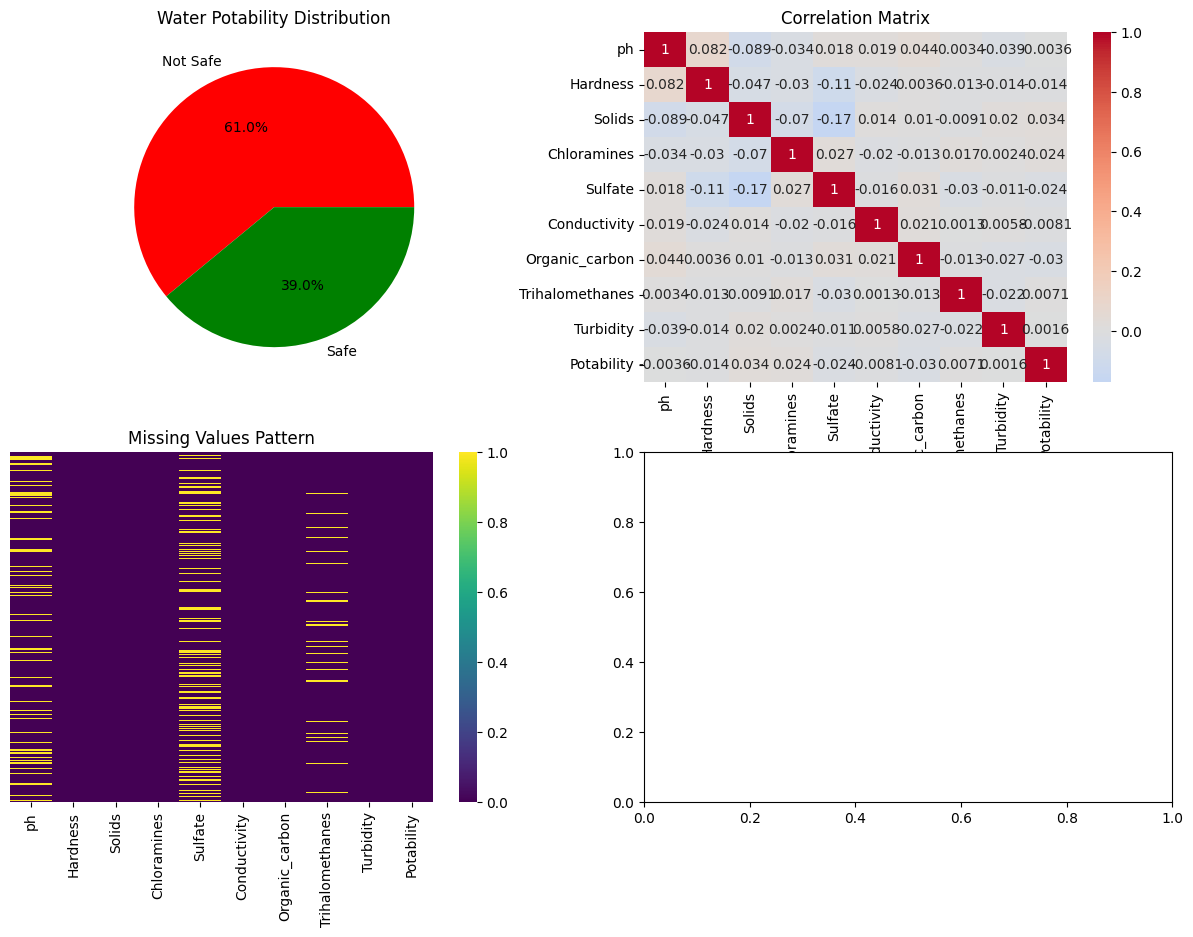

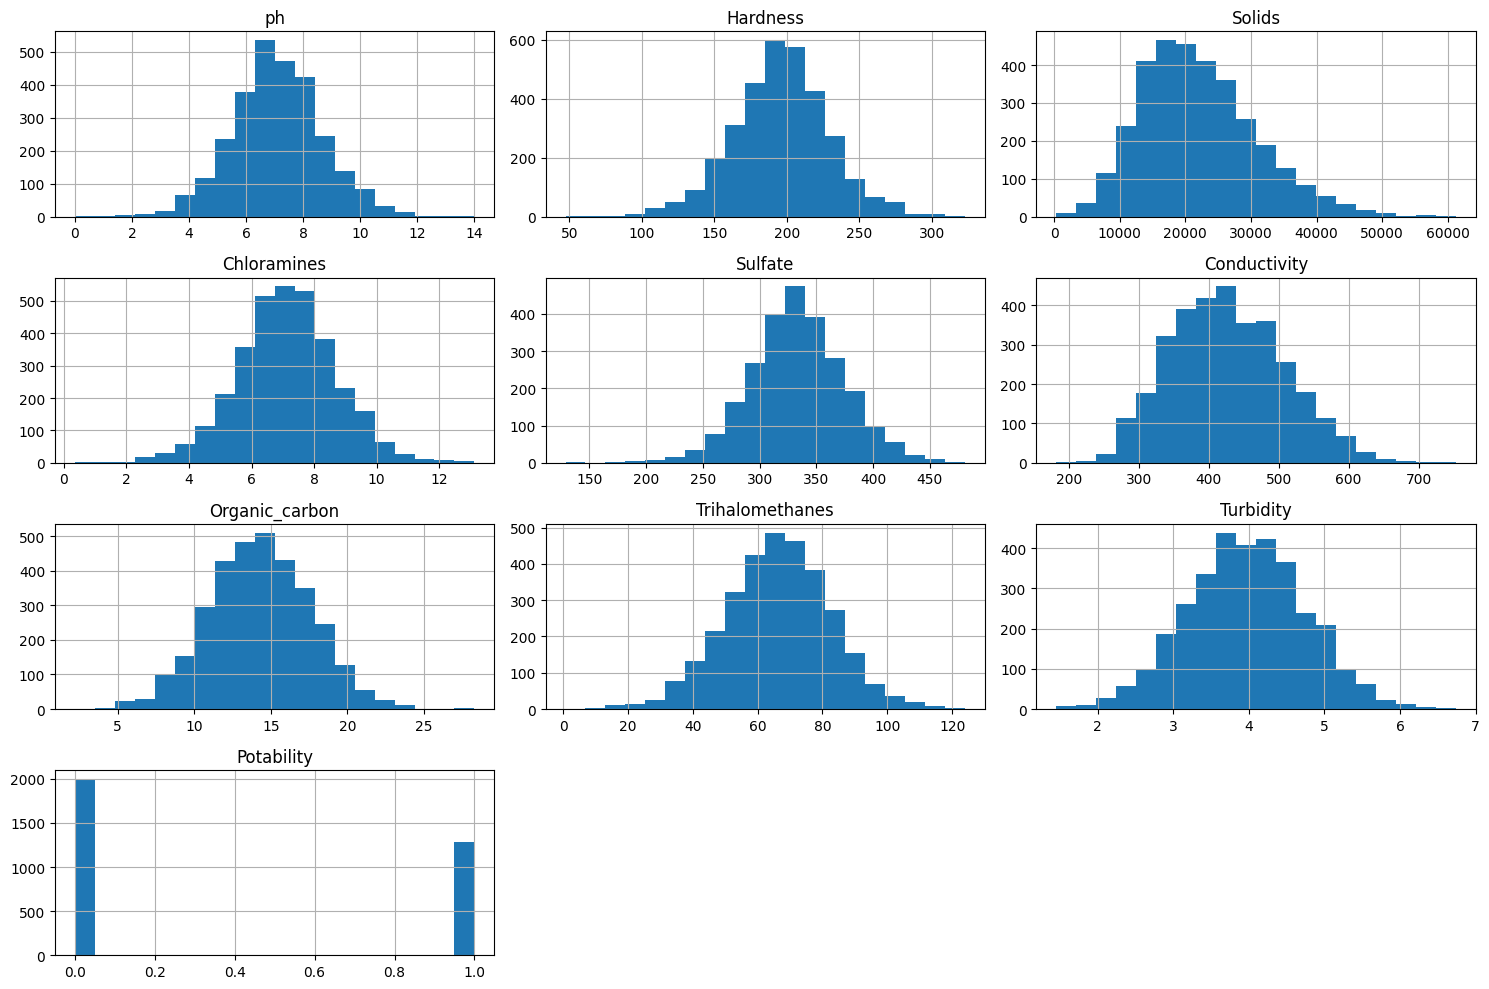

In [12]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Target distribution
axes[0,0].pie(df['Potability'].value_counts(), labels=['Not Safe', 'Safe'],
              autopct='%1.1f%%', colors=['red', 'green'])
axes[0,0].set_title('Water Potability Distribution')

# Correlation heatmap
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, ax=axes[0,1])
axes[0,1].set_title('Correlation Matrix')

# Missing values heatmap
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis', ax=axes[1,0])
axes[1,0].set_title('Missing Values Pattern')
plt.savefig("myplot3.pdf")

# Feature distributions
df.hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.savefig("myplot4.pdf")
plt.show()

2.4 Data Preprocessing

In [13]:
# Handle missing values
print("Before handling missing values:")
print(df.isnull().sum())

# Fill missing values with median (robust to outliers)
for column in df.columns:
    if df[column].isnull().sum() > 0:
        median_value = df[column].median()
        df[column].fillna(median_value, inplace=True)

print("\nAfter handling missing values:")
print(df.isnull().sum())

# Detect and handle outliers using IQR method
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

# Apply outlier handling to all numeric columns except target
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove('Potability')

for col in numeric_columns:
    df = handle_outliers(df, col)

print("Outlier handling completed!")

Before handling missing values:
ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

After handling missing values:
ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64
Outlier handling completed!


2.5 Prepare Data for Machine Learning

In [14]:
# Separate features and target
X = df.drop('Potability', axis=1)
y = df['Potability']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data prepared for training!")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Data prepared for training!
Training set shape: (2620, 9)
Test set shape: (656, 9)


2.6 Train Multiple Models

In [15]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Support Vector Machine': SVC(random_state=42)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")

    # Train model
    if name == 'Support Vector Machine':
        model.fit(X_train_scaled, y_train)
        predictions = model.predict(X_test_scaled)
    else:
        model.fit(X_train_scaled, y_train)
        predictions = model.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    results[name] = accuracy

    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))

# Find best model
best_model_name = max(results, key=results.get)
best_accuracy = results[best_model_name]

print(f"\n🏆 Best Model: {best_model_name} with accuracy: {best_accuracy:.4f}")


--- Training Logistic Regression ---
Accuracy: 0.6098

Classification Report:
              precision    recall  f1-score   support

           0       0.61      1.00      0.76       400
           1       0.00      0.00      0.00       256

    accuracy                           0.61       656
   macro avg       0.30      0.50      0.38       656
weighted avg       0.37      0.61      0.46       656


--- Training Random Forest ---
Accuracy: 0.6585

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.88      0.76       400
           1       0.62      0.31      0.42       256

    accuracy                           0.66       656
   macro avg       0.65      0.60      0.59       656
weighted avg       0.65      0.66      0.63       656


--- Training Support Vector Machine ---
Accuracy: 0.6646

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.91      0.77       400
   

2.7 Model Optimization & Final Training

In [16]:
# Train the best model (usually Random Forest performs well)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best model
final_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Final predictions
final_predictions = final_model.predict(X_test_scaled)
final_accuracy = accuracy_score(y_test, final_predictions)

print(f"\n🎯 Final Model Accuracy: {final_accuracy:.4f}")

# Save model and scaler
joblib.dump(final_model, 'water_quality_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Model and scaler saved successfully!")

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

🎯 Final Model Accuracy: 0.6707
Model and scaler saved successfully!


In [17]:
import joblib
import numpy as np

# Load the model and scaler
model = joblib.load('water_quality_model.pkl')
scaler = joblib.load('scaler.pkl')

# ✅ Example input (replace with your dataset's feature values in correct order)
# Suppose your dataset has 9 features: [pH, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity]
sample_input = np.array([[7.2, 204.0, 20791.0, 7.3, 330.0, 450.0, 14.0, 75.0, 3.5]])

# Scale the input (important: use the same scaler used for training)
scaled_input = scaler.transform(sample_input)

# Make prediction
prediction = model.predict(scaled_input)
probability = model.predict_proba(scaled_input)

print("🔍 Prediction (0 = Not Safe, 1 = Safe):", prediction[0])
print("📊 Probabilities [Not Safe, Safe]:", probability[0])


🔍 Prediction (0 = Not Safe, 1 = Safe): 0
📊 Probabilities [Not Safe, Safe]: [0.71816667 0.28183333]


In [18]:
import os
import json
from datetime import datetime

# Create directory structure
directories = [
    'water-quality-prediction',
    'water-quality-prediction/data/raw',
    'water-quality-prediction/data/processed',
    'water-quality-prediction/notebooks',
    'water-quality-prediction/src',
    'water-quality-prediction/models',
    'water-quality-prediction/visualizations',
    'water-quality-prediction/app',
    'water-quality-prediction/docs',
    'water-quality-prediction/tests'
]

for directory in directories:
    os.makedirs(directory, exist_ok=True)
    print(f"✅ Created: {directory}")

print("\n🎉 Repository structure created successfully!")

✅ Created: water-quality-prediction
✅ Created: water-quality-prediction/data/raw
✅ Created: water-quality-prediction/data/processed
✅ Created: water-quality-prediction/notebooks
✅ Created: water-quality-prediction/src
✅ Created: water-quality-prediction/models
✅ Created: water-quality-prediction/visualizations
✅ Created: water-quality-prediction/app
✅ Created: water-quality-prediction/docs
✅ Created: water-quality-prediction/tests

🎉 Repository structure created successfully!
